# Assignment 2: Multiplier-Accelerator Model and Kernel Estimation
Kiran Ferrini

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)  #set default figure size
import seaborn as sns
import numpy as np
from quantecon import LinearStateSpace
import cmath
import math
import sympy
from sympy import Symbol, init_printing
from cmath import sqrt
from scipy.stats import beta
from scipy.stats import norm

## Question 1:
Construct a version of the Samuelson Model that has neither damped nor explosive roots and period 16.   
- The three initial conditions are $Y_0 = Y_1 = Y_2 = 656.8535592272043$.  
- There is no government spending.

Deliverables: 
1. Give the consumption function.
2. Give the investment fuction. 
3. Give the GDP Identity. 
4. Plot the deterministic version of the model for 100 periods. 

**Consumption Function:**  
$$
C_t = aY_{t-1} + \gamma
$$  

**Investment Function:**   
$$
I_t = b(Y_{t-1} - Y_{t-2})
$$

**National Income Function (simplified with 0 net exports):**  
$$
Y_t = C_t + I_t + G_t
$$


This model is neither damped nor explosive so we know the modulus ($r$) must be 1. We also know that the period is 16. so we can obtain the angle (ϕ) by dividing $2\pi$ by our number of periods.    

In [4]:
r = 1   # Generates undamped, nonexplosive cycles

period = 16   # Length of cycle in units of time
ϕ = 2 * math.pi/period

print(r)
print(ϕ)

1
0.39269908169872414


Given these, $a$ and $b$ can be reverse engineered. 

In [5]:
def f(r, ϕ):
    """
    Takes modulus r and angle ϕ of complex number r exp(j ϕ)
    and creates ρ1 and ρ2 of characteristic polynomial for which
    r exp(j ϕ) and r exp(- j ϕ) are complex roots.

    Returns the multiplier coefficient a and the accelerator coefficient b
    that verifies those roots.
    """
    g1 = cmath.rect(r, ϕ)  # Generate two complex roots
    g2 = cmath.rect(r, -ϕ)
    ρ1 = g1 + g2           # Implied ρ1, ρ2
    ρ2 = -g1 * g2
    b = -ρ2                # Reverse-engineer a and b that validate these
    a = ρ1 - b
    return ρ1, ρ2, a, b

ρ1, ρ2, a, b = f(r, ϕ)

# Drop the imaginary part so that it is a valid input into y_nonstochastic
a = a.real
b = b.real

print(f"a, b = {a}, {b}")

a, b = 0.8477590650225735, 1.0


The initial condition of $Y_0 = Y_1 = Y_2 = 656.8535592272043$ implies that $I_2 = 0$ when $Y_1$ and $Y_0$ are plugged into the investment function. Because $I_2 = 0$ and we also assume $G_t = 0$ for all $t$, it is implied that $Y_2 = C_2$ from the national income function. Now that $a$ and $b$ are known, $\gamma$ can be calculated by plugging $C_2$ and $Y_1$ into the consumption equation:
$$
C_t = aY_{t-1} + \gamma \Rightarrow 656.8535592272043 = 0.8477590650225735(656.8535592272043) + \gamma \Rightarrow \gamma = 100
$$
With $a$, $b$ and $\gamma$ known:  
**Consumption Function:**  
$$
C_t = 0.8477590650225735(Y_{t-1}) + 100$$  

**Investment Function:**   
$$I_t = 1(Y_{t-1} - Y_{t-2})$$

**National Income Function:**  
$$Y_t = C_t + I_t$$


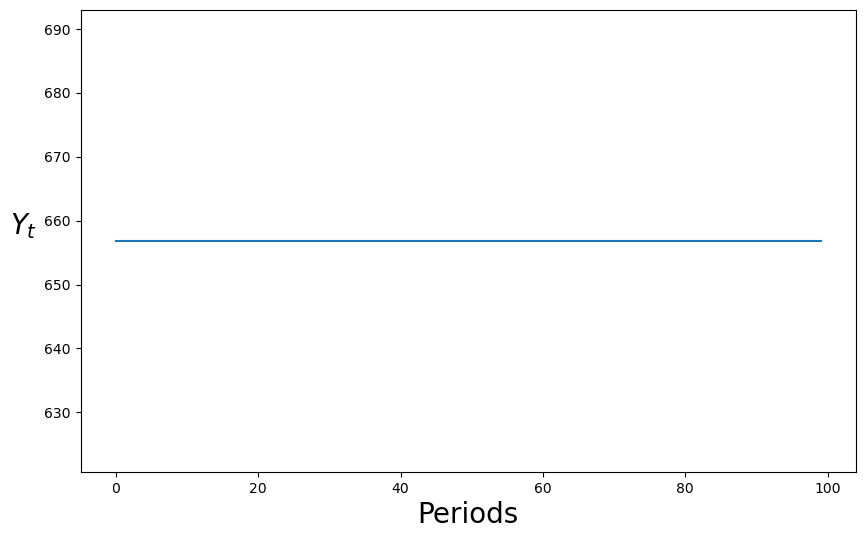

In [6]:
def y_nonstochastic(y_0=100, y_1=80, α=.9, β=.8, γ=10, n=80):

    """ Rather than computing the roots of the characteristic
    polynomial by hand as we did earlier, this function
    enlists numpy to do the work for us
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])

    # Define transition equation
    def transition(x, t): return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ

    # Set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):
        y_t.append(transition(y_t, t))

    return y_t

plt.plot(y_nonstochastic(α=a, β=b, y_0=656.8535592272043, y_1=656.8535592272043, γ=100, n=100))
plt.xlabel('Periods', fontsize=20)
plt.ylabel('$Y_t$', fontsize=20, rotation='horizontal', labelpad=15)
plt.show()

## Question 2:  
Now simulate a Presidential election using a stochastic version of the model with the same parameters. 
- The candidate is elected in period 16, and they implement a one-off government spending of 10.
- Keep the variance of the shock for the method `y_stochastic_g()` at $\sigma = 2$.
- Use random seed 1234. 

Deliverables:  
1. Plot the stochastic version of the model for 100 periods.
2. Do you think government spending induces the business cycle? 

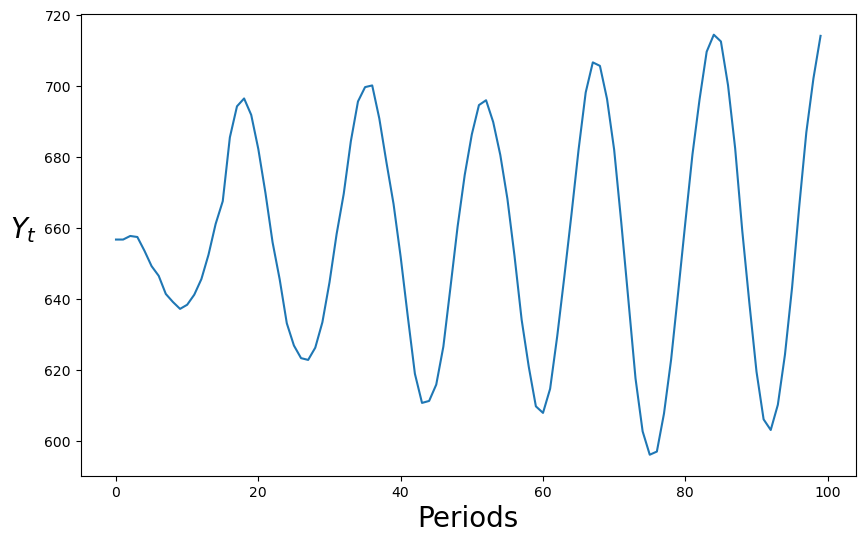

In [7]:
def y_stochastic_g(y_0=20,
                   y_1=20,
                   α=0.8,
                   β=0.2,
                   γ=10,
                   n=100,
                   σ=2,
                   g=0,
                   g_t=0,
                   duration='permanent'):

    """This program computes a response to a permanent or one-off increase
    in government expenditures that occurs at time 20
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])

    # Generate shocks
    ϵ = np.random.normal(0, 1, n)

    def transition(x, t, g):

        # Non-stochastic - separated to avoid generating random series
        # when not needed
        if σ == 0:
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g

        # Stochastic
        else:
            ϵ = np.random.normal(0, 1, n)
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g + σ * ϵ[t]

    # Create list and set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):

        # No government spending
        if g == 0:
            y_t.append(transition(y_t, t))

        # Government spending (no shock)
        elif g != 0 and duration == None:
            y_t.append(transition(y_t, t))

        # Permanent government spending shock
        elif duration == 'permanent':
            if t < g_t:
                y_t.append(transition(y_t, t, g=0))
            else:
                y_t.append(transition(y_t, t, g=g))

        # One-off government spending shock
        elif duration == 'one-off':
            if t == g_t:
                y_t.append(transition(y_t, t, g=g))
            else:
                y_t.append(transition(y_t, t, g=0))
    return y_t

np.random.seed(1234)
plt.plot(y_stochastic_g(α=a, β=b, y_0=656.8535592272043, y_1=656.8535592272043, γ=100, n=100, g=10, g_t=16, duration='one-off'))
plt.xlabel('Periods', fontsize=20)
plt.ylabel('$Y_t$', fontsize=20, rotation='horizontal', labelpad=15)
plt.show()

Yes government spending appears to induce the business cycle. The simulation shows that the one-off government spending increased the amplitude of national income, making the cyclical properties of $Y_t$ more pronounced. This can be shown more apparantly in the graph below, which shows the results of the spending being introduced at the 80th period. 

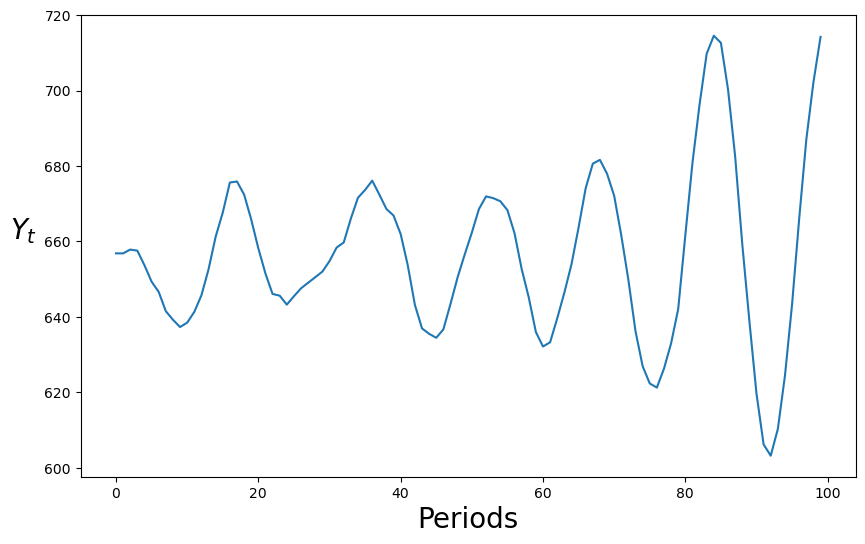

In [8]:
np.random.seed(1234)
plt.plot(y_stochastic_g(α=a, β=b, y_0=656.8535592272043, y_1=656.8535592272043, γ=100, n=100, g=10, g_t=80, duration='one-off'))
plt.xlabel('Periods', fontsize=20)
plt.ylabel('$Y_t$', fontsize=20, rotation='horizontal', labelpad=15)
plt.show()

## Question 3: 
Last year, there were 35 students in Econ 512.  They graciously assented to writing down their weights in pounds.  
Deliverables:
1. Use kernel estimation to estimate the distribution from which the students weights were drawn. Plot the estimated distribution using the grid from 90 to 230 with an interval being one pound.  
3. In your plot, also include the default histogram.  
4. Give your best guess of how many women and how many men were in the class last year.  

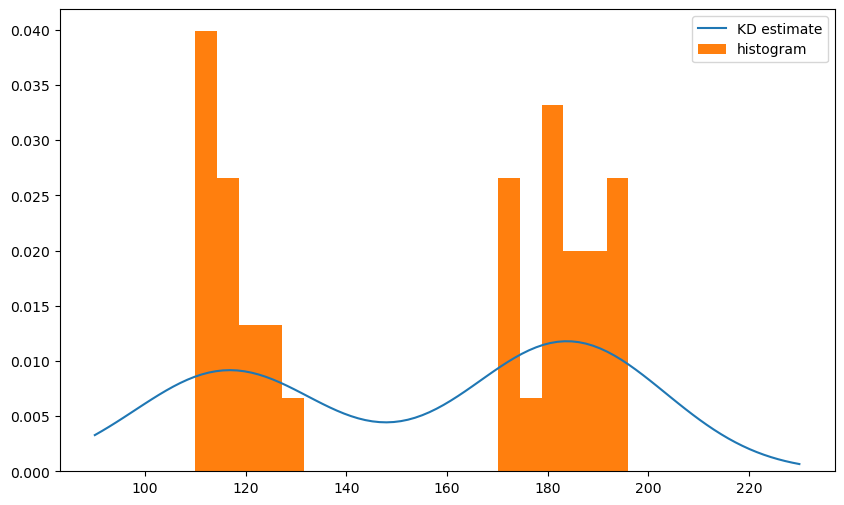

20 57.14285714285714
15 42.857142857142854


In [11]:
x_data = np.array([182,127,117,187,110,176,189,174,112,112,115,171,119,179,172,189,195,125,116,182,181,186,196,110,111,129,193,122,189,118,171,110,186,194,183])

K = norm.pdf

class KDE:

    def __init__(self, x_data, h=None):

        if h is None:
            c = x_data.std()
            n = len(x_data)
            h = 1.06 * c * n**(-1/5)
        self.h = h
        self.x_data = x_data

    def f(self, x):
        if np.isscalar(x):
            return K((x - self.x_data) / self.h).mean() * (1/self.h)
        else:
            y = np.empty_like(x)
            for i, x_val in enumerate(x):
                y[i] = K((x_val - self.x_data) / self.h).mean() * (1/self.h)
            return y
        
def plot_kde(x_data, x_min=90, x_max=230):
    kde = KDE(x_data)
                                                
    x_grid = np.linspace(x_min, x_max, 100)
    fig, ax = plt.subplots()
    ax.plot(x_grid, kde.f(x_grid), label="KD estimate")
    ax.hist(x_data, bins=20, density=True ,label="histogram")
    ax.legend()
    plt.show()


plot_kde(x_data)

from bisect import bisect
split = 150
x_data.sort()
men = len(x_data) - bisect(x_data, split)
n = len(x_data)
women = n - men
menpct = (men/n)*100
womenpct = (women/n)*100

print(men, menpct)
print(women, womenpct)

According to the [CDC](https://www.cdc.gov/nchs/fastats/body-measurements.htm) the average weight for men in the US is 20 lbs. higher than the weight of women. While gender is certainly not the only factor that contributes to weight, with only this information my best guess is that the heavier weights are men and the lighter weights are women. It is worth noting that this is a very unrealistic assumption.   

The data shows two distict groups. There are 15 people in the lighter weight range and 20 people in the heavier weight range. I can only assume that there were 15 women (43%) and 20 men (58%).